In [1]:
# import warnings
# warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from tde import time_delay_embedding
import seaborn as sns


In [2]:
# Process the Excel file
file=pd.ExcelFile('Wind_data.xlsx')
df_train=pd.read_excel(file,'Train')
df_pred=pd.read_excel(file,'Predict')
df_train["DATETIME"]=pd.to_datetime(df_train["DATETIME"])
# Setting DT as index
df_train.set_index('DATETIME', inplace=True)

# Make sure the data has clear frequency pattern of 1 hour.

df_train=df_train.resample('1H').mean()

# print(df_train)

# Check if anydata is missing. 
value = df_train.isnull().values.any()
print(value)

# Missing value detected, use 'interpolate' method in pandas to replace missing values with the interpolation of two adjacent points.
df_train=df_train.interpolate()
# Check if anydata is missing.
value = df_train.isnull().values.any()
print(value)

print(df_train)
# No NAN is detected this time.

# # Visualize data using seaborn
# sns.set(rc={'figure.figsize':(12,8)})
# sns.lineplot(x=df_train.index, y=df_train['CF'])
# sns.lineplot(x=df_train.index, y=df_train['WS_1133733'])
# sns.lineplot(x=df_train.index, y=df_train['WS_1513782'])
# plt.legend(['CF', 'WS_1133733','WS_1513782'])

True
False
                           CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2019-08-07 00:00:00  0.652524       10.35        8.99        4.57        9.69   
2019-08-07 01:00:00  0.605852        9.70        8.28        5.78        9.10   
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   
...                       ...         ...         ...         ...         ...   
2020-01-07 19:00:00  0.004494        1.56        1.62        2.44        1.81   
2020-01-07 20:00:00  0.006143        1.51        1.55        2.13        1.93   
2020-01-07 21:00:00  0.008399        1.51        1.62        2.42        1.82   
2020-01-07 22:00:00  0.015788        1.53        1.73        2.22        1.83   
2020-01-07 23:00:

In [3]:
# A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

# There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE.


cor = df_train.corr()
#Correlation with output variable
cor_target = abs(cor["CF"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.6]
df_selected=df_train[relevant_features.index]
df_selected=df_selected.drop('CF',axis=1)
df_selected

,WS_1133733,WS_1156770,WS_1369320,WS_1481513,WS_1504146,WS_1513782,WS_1513805,WS_1571308,WS_1574484,WS_1820279,...,WS_78205,WS_78207,WS_78208,WS_839753,WS_875373,WS_883683,WS_883699,WS_918665,WS_920775,WS_921049
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-08-07 00:00:00,10.35,8.99,11.14,15.46,10.70,9.66,9.72,11.02,9.90,8.17,...,10.77,9.82,11.12,9.31,11.63,10.72,10.55,10.77,10.17,9.24
2019-08-07 01:00:00,9.70,8.28,10.49,14.90,10.33,9.59,9.64,9.73,9.48,7.42,...,10.12,9.21,10.47,9.50,11.10,11.02,9.91,10.98,10.16,9.09
2019-08-07 02:00:00,9.04,7.39,10.12,14.22,10.01,9.59,9.63,8.92,9.11,6.91,...,9.61,8.40,10.10,9.46,10.74,11.19,9.52,11.10,10.04,9.04
2019-08-07 03:00:00,8.78,7.49,9.65,13.53,9.99,9.44,9.47,8.60,8.82,6.84,...,9.22,8.24,9.67,9.45,10.65,11.27,9.11,11.18,10.20,8.89
2019-08-07 04:00:00,8.23,6.88,9.21,12.84,9.31,9.20,9.22,7.19,8.63,6.61,...,8.70,7.61,9.24,9.30,9.78,10.85,8.64,10.83,9.88,8.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 19:00:00,1.56,1.62,1.42,0.86,1.75,1.54,1.44,1.64,1.14,2.68,...,1.80,1.41,1.41,1.04,1.48,1.55,1.94,1.30,1.22,1.60
2020-01-07 20:00:00,1.51,1.55,1.30,0.79,1.33,1.84,1.73,1.09,1.12,2.31,...,1.73,1.72,1.32,0.88,1.12,1.32,1.87,1.42,1.05,1.87
2020-01-07 21:00:00,1.51,1.62,1.41,0.64,1.21,1.99,1.88,1.03,1.32,1.79,...,1.73,1.76,1.26,1.28,0.87,1.37,1.83,1.44,1.32,2.05


In [4]:
corr = df_selected.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False

selected_columns = df_selected.columns[columns]

df_train_selected=df_selected[selected_columns]
Y=df_train.loc[:, 'CF']
df_train_selected=df_train_selected.assign(CF = Y.tolist())
df_train_selected


,WS_1133733,WS_1504146,WS_1513782,WS_1820279,CF
DATETIME,,,,,
2019-08-07 00:00:00,10.35,10.70,9.66,8.17,0.652524
2019-08-07 01:00:00,9.70,10.33,9.59,7.42,0.605852
2019-08-07 02:00:00,9.04,10.01,9.59,6.91,0.564094
2019-08-07 03:00:00,8.78,9.99,9.44,6.84,0.532721
2019-08-07 04:00:00,8.23,9.31,9.20,6.61,0.495608
...,...,...,...,...,...
2020-01-07 19:00:00,1.56,1.75,1.54,2.68,0.004494
2020-01-07 20:00:00,1.51,1.33,1.84,2.31,0.006143
2020-01-07 21:00:00,1.51,1.21,1.99,1.79,0.008399


In [5]:
# create data set with lagged features using time delay embedding
features_with_lag = []
for col in df_train_selected:
    col_df = time_delay_embedding(df_train_selected[col], n_lags=24, horizon=1)
    features_with_lag.append(col_df)

# Concatenating all features
allfeature_df=pd.concat(features_with_lag, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
input_cols = [col for col in allfeature_df.columns if 'WS_' in col and '(t+' not in col]

X = allfeature_df.loc[:, input_cols]
Y = allfeature_df.loc[:, 'CF(t)']
X.columns

Index(['WS_1133733(t-23)', 'WS_1133733(t-22)', 'WS_1133733(t-21)',
       'WS_1133733(t-20)', 'WS_1133733(t-19)', 'WS_1133733(t-18)',
       'WS_1133733(t-17)', 'WS_1133733(t-16)', 'WS_1133733(t-15)',
       'WS_1133733(t-14)', 'WS_1133733(t-13)', 'WS_1133733(t-12)',
       'WS_1133733(t-11)', 'WS_1133733(t-10)', 'WS_1133733(t-9)',
       'WS_1133733(t-8)', 'WS_1133733(t-7)', 'WS_1133733(t-6)',
       'WS_1133733(t-5)', 'WS_1133733(t-4)', 'WS_1133733(t-3)',
       'WS_1133733(t-2)', 'WS_1133733(t-1)', 'WS_1133733(t)',
       'WS_1504146(t-23)', 'WS_1504146(t-22)', 'WS_1504146(t-21)',
       'WS_1504146(t-20)', 'WS_1504146(t-19)', 'WS_1504146(t-18)',
       'WS_1504146(t-17)', 'WS_1504146(t-16)', 'WS_1504146(t-15)',
       'WS_1504146(t-14)', 'WS_1504146(t-13)', 'WS_1504146(t-12)',
       'WS_1504146(t-11)', 'WS_1504146(t-10)', 'WS_1504146(t-9)',
       'WS_1504146(t-8)', 'WS_1504146(t-7)', 'WS_1504146(t-6)',
       'WS_1504146(t-5)', 'WS_1504146(t-4)', 'WS_1504146(t-3)',
       'WS_150

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
import xgboost

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.2, shuffle=False)

# fitting a RF model
model = RandomForestRegressor()
model.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds = model.predict(X_ts)


# computing MAE error
print(mae(Y_ts, preds))

ModuleNotFoundError: No module named 'xgboost'

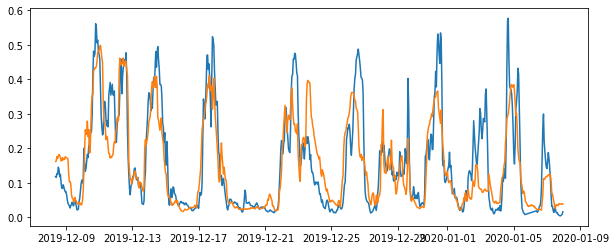

In [7]:
plt.figure(figsize=(10,4))
# plt.plot(Y_tr.index,Y_tr.values)
plt.plot(Y_ts.index,Y_ts.values)
plt.plot(Y_ts.index,preds)

In [8]:
# getting importance scores from previous model
importance_scores = pd.Series(dict(zip(X_tr.columns, model.feature_importances_)))

# evaluate effects of number of features getting top n features
error_data=pd.DataFrame(index=np.arange(100), columns=np.arange(20))
for i in range(1,20):
    for j in range(10):
        top_features = importance_scores.sort_values(ascending=False)[:i]
        top_features_nm = top_features.index

        X_tr_top = X_tr[top_features_nm]
        X_ts_top = X_ts[top_features_nm]

        # re-fitting the model
        model_top_features = RandomForestRegressor()
        model_top_features.fit(X_tr_top, Y_tr)

        # getting forecasts for the test set
        preds_topf = model_top_features.predict(X_ts_top)

        # computing MAE error
        error_data.iloc[j,i]=mae(Y_ts, preds_topf)
    # print(mae(Y_ts, preds_topf))
    

    No_of_features       Mean          STD
0                0        NaN          NaN
1                1  0.0863962   0.00036712
2                2  0.0665454  0.000303123
3                3  0.0621798  0.000341406
4                4   0.056263   0.00037195
5                5  0.0568294  0.000446979
6                6  0.0529248  0.000229599
7                7  0.0527306  0.000363152
8                8  0.0585255  0.000325985
9                9  0.0583376  0.000214231
10              10  0.0578181   0.00035077
11              11  0.0574826  0.000161937
12              12  0.0568941  0.000375079
13              13  0.0567044  0.000179349
14              14  0.0569579  0.000280645
15              15  0.0562958  0.000413149
16              16  0.0562495  0.000567259
17              17  0.0557394  0.000217321
18              18  0.0557504  0.000347162


c:\Users\limen\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0, 0.5, 'MAE')

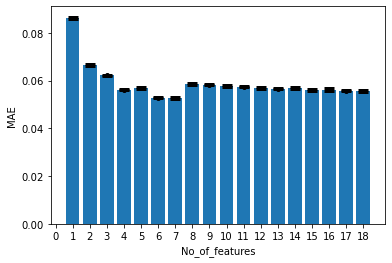

In [11]:
df=pd.DataFrame()
df['No_of_features']=np.arange(19)
df['Mean']=None
df['STD']=None

for i in range(19):
    df['Mean'].iloc[i]=error_data.iloc[:,i].mean()
    df['STD'].iloc[i]=error_data.iloc[:,i].std()

print(df)
plt.errorbar( df['No_of_features'], df['Mean'], yerr=df['STD'], fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.bar(df['No_of_features'], df['Mean'],tick_label = df['No_of_features'])##Bar plot
plt.xlabel('No_of_features') ## Label on X axis
plt.ylabel('MAE') ##Label on Y axis

In [12]:
top_features = importance_scores.sort_values(ascending=False)[:7]
top_features_nm = top_features.index

X_tr_top = X_tr[top_features_nm]
X_ts_top = X_ts[top_features_nm]
top_features_nm

Index(['WS_1513782(t)', 'WS_1133733(t)', 'WS_1133733(t-1)', 'WS_1504146(t-1)',
       'WS_1504146(t)', 'WS_1513782(t-1)', 'WS_1504146(t-2)'],
      dtype='object')

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_tr_top, Y_tr)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 900,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [18]:
def evaluate(model, X_ts, Y_ts):
    predictions = model.predict(X_ts)
    errors = abs(predictions - Y_ts)
    mae = np.mean(errors)
    print('Model Performance')
    print('MAE: {:0.4f}.'.format(np.mean(mae)))
    return mae

base_model = RandomForestRegressor(n_estimators=100,random_state=1)

base_model.fit(X_tr_top, Y_tr)
mae_base = evaluate(base_model, X_ts_top, Y_ts)

best_random = rf_random.best_estimator_
mae_best = evaluate(best_random,  X_ts_top, Y_ts)

print('Improvement of {:0.4f}%.'.format( 100 * (mae_base-mae_best) / mae_base))

Model Performance
MAE: 0.0534.
Model Performance
MAE: 0.0533.
Improvement of 0.1942%.


In [19]:
# {'n_estimators': 900,
#  'min_samples_split': 10,
#  'min_samples_leaf': 4,
#  'max_features': 'sqrt',
#  'max_depth': 100,
#  'bootstrap': True}


from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['sqrt'],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [600,650, 700, 750, 800]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_tr_top, Y_tr)
grid_search.best_params_

Fitting 3 folds for each of 135 candidates, totalling 405 fits


{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 750}

In [20]:
best_random = rf_random.best_estimator_
mae_best_random = evaluate(best_random,  X_ts_top, Y_ts)

best_grid = grid_search.best_estimator_
mae_best_grid = evaluate(best_grid, X_ts_top, Y_ts)

print('Improvement of {:0.4f}%.'.format( 100 * (mae_best_random-mae_best_grid) / mae_best_random))

Model Performance
MAE: 0.0533.
Model Performance
MAE: 0.0536.
Improvement of -0.5372%.


# Investigation: What if the previous measurement(s) of CF is also used as an input variable 

## One step ahead forecasting

In [59]:
# In one step ahead forecasting, CF(t-1), CF(t-2),...CF(t-n)
# can also be used to predict CF(t) together with other variables
# Through the same feature selection procedure before, CF(t-1) is more important than data with other lags

print(list(top_features_nm))
input_with_CF=list(top_features_nm)+['CF(t-1)']

X2 = allfeature_df.loc[:, input_with_CF]
Y = allfeature_df.loc[:, 'CF(t)']
X2.columns


['WS_1513782(t)', 'WS_1133733(t)', 'WS_1133733(t-1)', 'WS_1504146(t-1)', 'WS_1513782(t-1)']


Index(['WS_1513782(t)', 'WS_1133733(t)', 'WS_1133733(t-1)', 'WS_1504146(t-1)',
       'WS_1513782(t-1)', 'CF(t-1)'],
      dtype='object')

0.022083365536571246


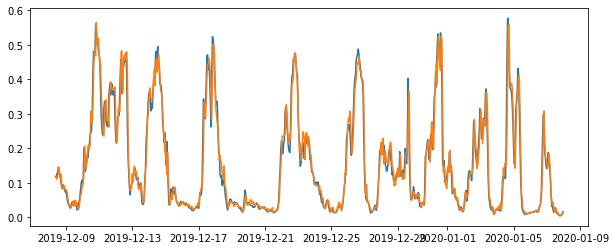

In [60]:
# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X2, Y, test_size=0.2, shuffle=False)

# fitting a RF model
model = RandomForestRegressor()
model.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds = model.predict(X_ts)


# computing MAE error
print(mae(Y_ts, preds))

plt.figure(figsize=(10,4))
# plt.plot(Y_tr.index,Y_tr.values)
plt.plot(Y_ts.index,Y_ts.values)
plt.plot(Y_ts.index,preds)

In [49]:
# #VAR
# from statsmodels.tsa.vector_ar.vecm import coint_johansen
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.vector_ar.var_model import VAR

# # Check for the stationary of the data before using any time-series statistical model
# # For multivariate time series data, we can either use johansen or adfuller test to verify the stationary of the data

# coint_johansen(df_train_selected,-1,1).eig



# for i in range(len(df_train_selected.columns)):
#     result=adfuller(df_train_selected[df_train_selected.columns[i]])
#     if result[1]>0.05:
#         print("Series is not stationary:", df_train_selected.columns[i], result[1])
#         result=adfuller(df_train_selected.iloc[:i].diff()[1:])
#         print("Adjusted result by differencing is:", df_train_selected.columns[i], result[1])

#     else:
#         print("Series is stationary:", df_train_selected.columns[i], result[1])

# # df_train_selected=df_train_selected.drop('')
# #creating the train and validation set
# train = df_train_selected[:int(0.8*(len(df_train_selected)))]
# test = df_train_selected[int(0.8*(len(df_train_selected))):]




In [43]:
# for i in [1,2,3,4,5,6,7,8,9,10]:
#     model = VAR(endog=train,freq='1H')
#     results = model.fit(i)
#     print('Order =', i)
#     print('AIC: ', results.aic)
#     print('BIC: ', results.bic)


# sorted_order=model.select_order(10)
# print(sorted_order.summary())


# model = VAR(endog=train,freq='1H')
# results = model.fit(6)

# lag=results.k_ar
# print(lag)
# pred=results.forecast(train.values[-lag:], steps=len(test))
# #converting predictions to dataframe

# cols = df_train_selected.columns

# print(pred)

# pred_df = pd.DataFrame(index=range(0,len(pred)),columns=[cols])
# for j in range(len(cols)):
#     for i in range(0, len(pred)):
#        pred_df.iloc[i][j] = pred[i][j]
       
# print(mae(pred_df.iloc[:,3].tolist(), test.iloc[:,3].tolist()))

# plt.figure(figsize=(10,4))
# # plt.plot(Y_tr.index,Y_tr.values)
# plt.plot(test.index,pred_df.iloc[:,3].tolist())
# plt.plot(test.index,test.iloc[:,3].tolist())

In [48]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error as mae
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True) # only valid on Windows

# 1.1.2 version



df_train_prophet=df_train_selected.reset_index()

print(df_train_prophet)
df_train_prophet.columns = ['ds','WS_1133733','WS_1504146','WS_1513782','WS_1820279', 'y']
# Train test split
#creating the train and validation set
train = df_train_prophet[:int(0.8*(len(df_train_prophet)))]
test = df_train_prophet[int(0.8*(len(df_train_prophet))):]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

# Use the default hyperparameters to initiate the Prophet model
m_base = Prophet()
# Fit the model on the training dataset
m_base.fit(train)

Installing CmdStan version: 2.32.2
Install directory: C:\Users\limen\.cmdstan
CmdStan version 2.32.2 already installed


20:11:02 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\limen\.cmdstan\RTools40
20:11:02 - cmdstanpy - INFO - Chain [1] start processing


Installing CmdStan version: 2.32.2
Install directory: C:\Users\limen\.cmdstan
Installing RTools40
C++ toolchain 'RTools' version: 4.0
Install directory: C:\Users\limen\.cmdstan
C++ toolchain RTools40 already installed
mingw32-make.exe already installed
CmdStan version 2.32.2 already installed
                DATETIME  WS_1133733  WS_1504146  WS_1513782  WS_1820279  \
0    2019-08-07 00:00:00       10.35       10.70        9.66        8.17   
1    2019-08-07 01:00:00        9.70       10.33        9.59        7.42   
2    2019-08-07 02:00:00        9.04       10.01        9.59        6.91   
3    2019-08-07 03:00:00        8.78        9.99        9.44        6.84   
4    2019-08-07 04:00:00        8.23        9.31        9.20        6.61   
...                  ...         ...         ...         ...         ...   
3691 2020-01-07 19:00:00        1.56        1.75        1.54        2.68   
3692 2020-01-07 20:00:00        1.51        1.33        1.84        2.31   
3693 2020-01-07 21:00:

20:11:02 - cmdstanpy - INFO - Chain [1] done processing
20:11:02 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
20:11:02 - cmdstanpy - INFO - Chain [1] start processing
20:11:02 - cmdstanpy - INFO - Chain [1] done processing
20:11:02 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Users\limen\Anaconda3\Lib\site-packages\prophet\stan_model\prophet_model.bin random seed=78146 data file=C:\Users\limen\AppData\Local\Temp\tmpzymam11o\w66i8jmq.json init=C:\Users\limen\AppData\Local\Temp\tmpzymam11o\3r8u_d_q.json output file=C:\Users\limen\AppData\Local\Temp\tmpzymam11o\prophet_modeluquja49t\prophet_model-20230823201102.csv method=optimize algorithm=newton iter=10000' failed: 

In [45]:
# prediction = m_base.predict(pd.DataFrame({'ds':test['ds']}))
# y_actual = test['y']
# y_predicted = prediction['yhat']
# y_predicted = y_predicted.astype(int)
# print(mae(y_actual, y_predicted))
# print(prediction)


# # My personal experience with data generated by hardware systems, like CPU metrics, is that Prophet tends to not do a great job because they often do not have the same type of structure as data generated by humans doing things, like consistent seasonal effects.

# # The reason the model is fitting poorly with the 5 months of data is because of how the extra regressor effect is modeled. The model is basically

# # y(t) = trend(t) + seasonality(t) + beta * regressor(t)
# # where regressor(t) is the binary vector that you specified, and beta is the effect that will be fit to the data.

# # As you can see, Prophet assumes that the regressor has a constant effect that is added to the trend. With the 1 month of data, this is pretty much the case - the trend is fairly flat, and the peak is flat on top of that. For the 5 months of data, it is not the case. The peak level stays fairly flat, but the trend goes up and down quite a bit. In early months there is little difference between the trend level and the peak level, but then in later months there is a large difference. So the model isn't able to fit a constant regressor effect that does a good job of capturing the data.

# # I think in this particular case, the best thing that I could recommend would be to separate the peak time out from the rest of the data and forecast the two separately. If you remove the peak times from your data, then the forecast should be able to do a better job at non-peak times. And then you could just insert into the forecast the peak value at all of the peak times (assuming it stays constant all the time, which it appears to. Or you could forecast it by itself too).
# m_base.plot(prediction); # Add semi-colon to remove the duplicated chart

In [30]:
# # Add seasonality
# model_season = Prophet(daily_seasonality=True, weekly_seasonality=True)
# # Fit the model on the training dataset
# model_season.fit(train)


In [29]:
# # Add seasonality 
# model_multivariate = Prophet(daily_seasonality=True, weekly_seasonality=True)
# # Add regressor
# model_multivariate.add_regressor('WS_1133733', standardize=False)
# # Fit the model on the training dataset
# model_multivariate.fit(train)

# # Create the time range for the forecast
# future_multivariate = model_multivariate.make_future_dataframe(periods=40)
# # Append the regressor values
# future_multivariate = pd.merge(future_multivariate, df_train_prophet[['ds', 'WS_1133733']], on='ds', how='inner')
# # Fill the missing values with the previous value
# future_multivariate = future_multivariate.fillna(method='ffill')
# # Check the data
# future_multivariate.tail(10)

In [28]:
# # Make prediction
# forecast_multivariate = model_multivariate.predict(future_multivariate)
# # Visualize the forecast
# model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart